In [1]:
#import necessary packages
import pandas as pd 
import splitfolders

from sklearn.dummy import DummyClassifier

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#use the splitfolders package to split our image data into train, validation, and test sets.
#this is now commented out so that we don't create a new folder each time we run the notebook

#splitfolders.ratio("Data", output="Data_Split",
#    seed=42, ratio=(.64, .16, .2), group_prefix=None, move=True)

In [3]:
#create DataGenerator objects for each set with rescaling for maximum pixel value of 255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
#create a train_generator from the training directory that has been created from the split folders package
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        'Data_Split/train',
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=4280,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary', 
        color_mode='grayscale')


Found 3749 images belonging to 2 classes.


In [5]:
#create a validation_generator from the training directory that has been created from the split folders package
validation_generator = val_datagen.flow_from_directory('Data_Split/val',
                                                        target_size=(150, 150),
                                                        batch_size=978,
                                                        class_mode='binary',
                                                        color_mode='grayscale')

Found 936 images belonging to 2 classes.


In [6]:
#create a test_generator from the training directory that has been created from the split folders package
test_generator = test_datagen.flow_from_directory('Data_Split/test',
                                                  target_size=(150, 150),
                                                  batch_size=1173,
                                                  class_mode='binary',
                                                  color_mode='grayscale')

Found 1107 images belonging to 2 classes.


In [7]:
train_data, train_labels = next(train_generator)

In [8]:
val_data, val_labels = next(validation_generator)

In [9]:
test_data, test_labels = next(test_generator)

### Dummy Model

We will create a dummy model for our baseline model that simply predicts the majority class, or in this case, that the patient has pneumonia. We can use the dummy classifier from sklearn. 

In [10]:
baseline = DummyClassifier(strategy='most_frequent')

In [11]:
baseline.fit(train_data, train_labels)

DummyClassifier(strategy='most_frequent')

In [12]:
baseline.score(train_data, train_labels)

0.7633177570093458

In [13]:
train_data = train_data.reshape(train_data.shape[0], -1)

In [14]:
val_data = val_data.reshape(val_data.shape[0], -1)

In [15]:
train_data.shape

(4280, 22500)

In [16]:
simple_model = models.Sequential()

In [17]:
simple_model.add(layers.Dense(12, activation='relu', input_shape=(22500,)))
simple_model.add(layers.Dense(1, activation='sigmoid'))

2022-08-02 08:05:10.178031: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 08:05:10.178350: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [18]:
simple_model.compile(optimizer='SGD', 
                       loss='binary_crossentropy',
                       metrics=['accuracy', metrics.Precision(), metrics.Recall()])

In [19]:
simple_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                270012    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 270,025
Trainable params: 270,025
Non-trainable params: 0
_________________________________________________________________


In [20]:
simple_fit = simple_model.fit(train_data,
                              train_labels,
                              epochs=10,
                              batch_size=32,
                              validation_data=(val_data, val_labels),
                              verbose=1)

Train on 4280 samples, validate on 978 samples
Epoch 1/10
4280/4280 [==============================] - 1s 304us/step - loss: 0.5496 - accuracy: 0.7528 - precision_1: 0.7639 - recall_1: 0.9786 - val_loss: 0.4814 - val_accuracy: 0.7413 - val_precision_1: 0.7413 - val_recall_1: 1.0000
Epoch 2/10
4280/4280 [==============================] - 1s 126us/step - loss: 0.3837 - accuracy: 0.7633 - precision_1: 0.7633 - recall_1: 1.0000 - val_loss: 0.3539 - val_accuracy: 0.7413 - val_precision_1: 0.7413 - val_recall_1: 1.0000
Epoch 3/10
4280/4280 [==============================] - 1s 128us/step - loss: 0.3217 - accuracy: 0.8610 - precision_1: 0.8656 - recall_1: 0.9682 - val_loss: 0.3382 - val_accuracy: 0.8589 - val_precision_1: 0.8433 - val_recall_1: 0.9945
Epoch 4/10
4280/4280 [==============================] - 1s 125us/step - loss: 0.2935 - accuracy: 0.9014 - precision_1: 0.9156 - recall_1: 0.9593 - val_loss: 0.2854 - val_accuracy: 0.9213 - val_precision_1: 0.9332 - val_recall_1: 0.9628
Epoch 5/1

In [21]:
#recreate our objects for features and labels in order to create simple convolutional neural network
train_data, train_labels = next(train_generator)

val_data, val_labels = next(validation_generator)

test_data, test_labels = next(test_generator)

In [22]:
basic_cnn_model = models.Sequential()
basic_cnn_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                    input_shape=(150, 150, 1)))
basic_cnn_model.add(layers.MaxPooling2D((2, 2)))
basic_cnn_model.add(layers.Flatten())
basic_cnn_model.add(layers.Dense(16, activation='relu'))
basic_cnn_model.add(layers.Dense(1, activation='sigmoid'))

basic_cnn_model.compile(optimizer="adam",
                        loss='binary_crossentropy',
                        metrics=['accuracy', metrics.Recall()])

basic_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 341056)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                5456912   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 5,458,017
Trainable params: 5,458,017
Non-trainable params: 0
_________________________________________________________________


In [23]:
basic_cnn_history = basic_cnn_model.fit(train_data,
                                        train_labels,
                                        batch_size=100,
                                        epochs=10,
                                        validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/10
4280/4280 [==============================] - 51s 12ms/step - loss: 0.7605 - accuracy: 0.7631 - recall_2: 0.9348 - val_loss: 0.3312 - val_accuracy: 0.8926 - val_recall_2: 0.9793
Epoch 2/10
4280/4280 [==============================] - 49s 12ms/step - loss: 0.2805 - accuracy: 0.9121 - recall_2: 0.9829 - val_loss: 0.3051 - val_accuracy: 0.8722 - val_recall_2: 0.9917
Epoch 3/10
4280/4280 [==============================] - 46s 11ms/step - loss: 0.2562 - accuracy: 0.9320 - recall_2: 0.9819 - val_loss: 0.2698 - val_accuracy: 0.9039 - val_recall_2: 0.9890
Epoch 4/10
4280/4280 [==============================] - 46s 11ms/step - loss: 0.2293 - accuracy: 0.9493 - recall_2: 0.9871 - val_loss: 0.2369 - val_accuracy: 0.9397 - val_recall_2: 0.9862
Epoch 5/10
4280/4280 [==============================] - 45s 11ms/step - loss: 0.2254 - accuracy: 0.9484 - recall_2: 0.9822 - val_loss: 0.2484 - val_accuracy: 0.9458 - val_recall_2: 0.9476
Epoch 6/10
42

In [58]:
pickle_model(basic_cnn_history)

What would you like to name the model?Simple CNN Zach


/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing ot

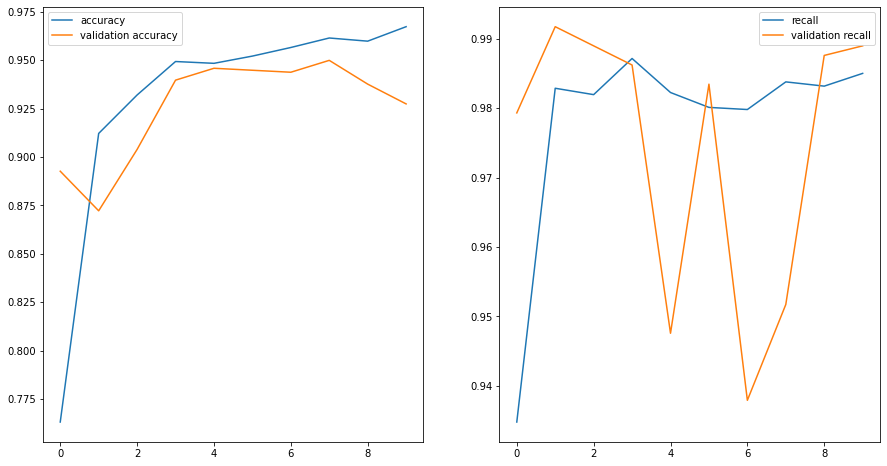

In [36]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.lineplot(basic_cnn_history.epoch, basic_cnn_history.history['accuracy'], ax=ax[0], label='accuracy');
sns.lineplot(basic_cnn_history.epoch, basic_cnn_history.history['val_accuracy'], ax=ax[0], label='validation accuracy');

sns.lineplot(basic_cnn_history.epoch, basic_cnn_history.history['recall_2'], ax=ax[1], label='recall');
sns.lineplot(basic_cnn_history.epoch, basic_cnn_history.history['val_recall_2'], ax=ax[1], label='validation recall');

In [37]:
complex_cnn_model = models.Sequential()
complex_cnn_model.add(layers.Conv2D(64, (4, 4), activation='relu',
                      input_shape=(150, 150, 1)))
complex_cnn_model.add(layers.MaxPooling2D((2, 2)))
complex_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
complex_cnn_model.add(layers.MaxPooling2D((2,2)))
complex_cnn_model.add(layers.Flatten())
complex_cnn_model.add(layers.Dense(16, activation='relu'))
complex_cnn_model.add(layers.Dense(1, activation='sigmoid'))

complex_cnn_model.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Recall()])

complex_cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 39200)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                627216    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [38]:
complex_cnn_history = complex_cnn_model.fit(train_data,
                                            train_labels,
                                            batch_size=32,
                                            epochs=10,
                                            validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/10
4280/4280 [==============================] - 69s 16ms/step - loss: 0.2701 - accuracy: 0.8864 - recall_3: 0.9654 - val_loss: 0.1507 - val_accuracy: 0.9407 - val_recall_3: 0.9448
Epoch 2/10
4280/4280 [==============================] - 69s 16ms/step - loss: 0.1498 - accuracy: 0.9442 - recall_3: 0.9700 - val_loss: 0.1453 - val_accuracy: 0.9407 - val_recall_3: 0.9862
Epoch 3/10
4280/4280 [==============================] - 66s 15ms/step - loss: 0.1324 - accuracy: 0.9519 - recall_3: 0.9721 - val_loss: 0.2581 - val_accuracy: 0.8937 - val_recall_3: 0.8579
Epoch 4/10
4280/4280 [==============================] - 65s 15ms/step - loss: 0.1330 - accuracy: 0.9519 - recall_3: 0.9746 - val_loss: 0.1360 - val_accuracy: 0.9427 - val_recall_3: 0.9379
Epoch 5/10
4280/4280 [==============================] - 64s 15ms/step - loss: 0.1006 - accuracy: 0.9640 - recall_3: 0.9795 - val_loss: 0.1124 - val_accuracy: 0.9530 - val_recall_3: 0.9807
Epoch 6/10
42

In [59]:
pickle_model(complex_cnn_history)

What would you like to name the model?2 Layer CNN Zach


/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing ot

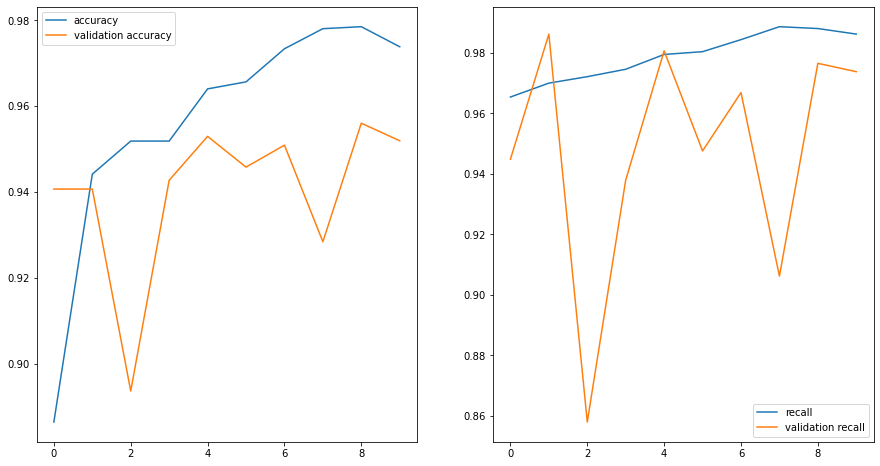

In [63]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.lineplot(complex_cnn_history.epoch, complex_cnn_history.history['accuracy'], ax=ax[0], label='accuracy');
sns.lineplot(complex_cnn_history.epoch, complex_cnn_history.history['val_accuracy'], ax=ax[0], label='validation accuracy');

sns.lineplot(complex_cnn_history.epoch, complex_cnn_history.history['recall_3'], ax=ax[1], label='recall');
sns.lineplot(complex_cnn_history.epoch, complex_cnn_history.history['val_recall_3'], ax=ax[1], label='validation recall');

In [40]:
complex_cnn_model2 = models.Sequential()
complex_cnn_model2.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
complex_cnn_model2.add(layers.MaxPooling2D((2, 2)))
complex_cnn_model2.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
complex_cnn_model2.add(layers.MaxPooling2D((2,2)))
complex_cnn_model2.add(layers.Flatten())
complex_cnn_model2.add(layers.Dense(16, activation='relu'))
complex_cnn_model2.add(layers.Dense(1, activation='sigmoid'))

complex_cnn_model2.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Recall()])

complex_cnn_model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 39200)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                627216    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [41]:
complex_cnn_history2 = complex_cnn_model2.fit(train_data,
                                              train_labels,
                                              batch_size=32,
                                              epochs=10,
                                              validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/10
4280/4280 [==============================] - 63s 15ms/step - loss: 0.9250 - accuracy: 0.8107 - recall_4: 0.9832 - val_loss: 0.3939 - val_accuracy: 0.9100 - val_recall_4: 0.9628
Epoch 2/10
4280/4280 [==============================] - 65s 15ms/step - loss: 0.3221 - accuracy: 0.9072 - recall_4: 0.9832 - val_loss: 0.3055 - val_accuracy: 0.9213 - val_recall_4: 0.9793
Epoch 3/10
4280/4280 [==============================] - 65s 15ms/step - loss: 0.2914 - accuracy: 0.9100 - recall_4: 0.9777 - val_loss: 0.2937 - val_accuracy: 0.9182 - val_recall_4: 0.9434
Epoch 4/10
4280/4280 [==============================] - 64s 15ms/step - loss: 0.2709 - accuracy: 0.9203 - recall_4: 0.9749 - val_loss: 0.2765 - val_accuracy: 0.9284 - val_recall_4: 0.9490
Epoch 5/10
4280/4280 [==============================] - 65s 15ms/step - loss: 0.2611 - accuracy: 0.9215 - recall_4: 0.9611 - val_loss: 0.2651 - val_accuracy: 0.9284 - val_recall_4: 0.9434
Epoch 6/10
42

In [60]:
pickle_model(complex_cnn_history2)

What would you like to name the model?2 Layer CNN w Regularization Zach


/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing ot

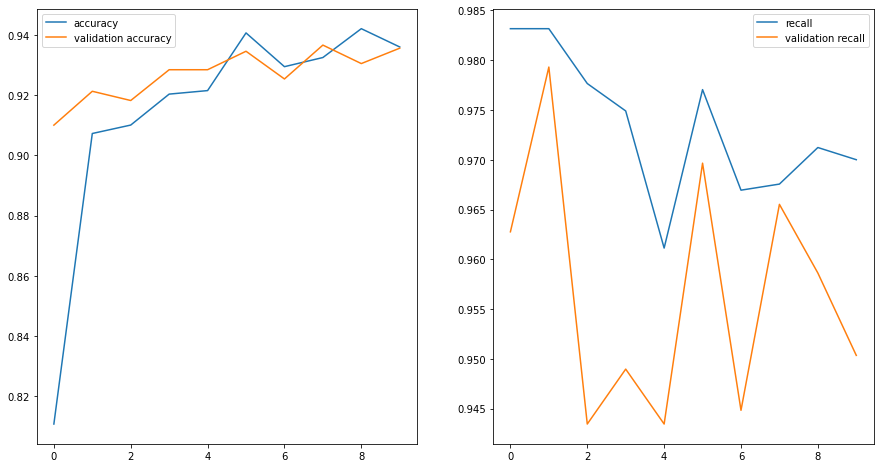

In [64]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.lineplot(complex_cnn_history2.epoch, complex_cnn_history2.history['accuracy'], ax=ax[0], label='accuracy');
sns.lineplot(complex_cnn_history2.epoch, complex_cnn_history2.history['val_accuracy'], ax=ax[0], label='validation accuracy');

sns.lineplot(complex_cnn_history2.epoch, complex_cnn_history2.history['recall_4'], ax=ax[1], label='recall');
sns.lineplot(complex_cnn_history2.epoch, complex_cnn_history2.history['val_recall_4'], ax=ax[1], label='validation recall');

In [43]:
complex_cnn_model3 = models.Sequential()
complex_cnn_model3.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
complex_cnn_model3.add(layers.MaxPooling2D((2, 2)))
complex_cnn_model3.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
complex_cnn_model3.add(layers.MaxPooling2D((2,2)))
complex_cnn_model3.add(layers.Flatten())
complex_cnn_model3.add(layers.Dense(16, activation='relu'))
complex_cnn_model3.add(layers.Dropout(0.5))
complex_cnn_model3.add(layers.Dense(1, activation='sigmoid'))

complex_cnn_model3.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Recall()])

complex_cnn_model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 39200)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                627216    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

In [44]:
complex_cnn_history3 = complex_cnn_model3.fit(train_data,
                                              train_labels,
                                              batch_size=32,
                                              epochs=10,
                                              validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/10
4280/4280 [==============================] - 65s 15ms/step - loss: 1.0686 - accuracy: 0.7617 - recall_5: 0.9972 - val_loss: 0.4824 - val_accuracy: 0.7413 - val_recall_5: 1.0000
Epoch 2/10
4280/4280 [==============================] - 61s 14ms/step - loss: 0.4480 - accuracy: 0.8019 - recall_5: 0.9507 - val_loss: 0.3534 - val_accuracy: 0.8957 - val_recall_5: 0.9793
Epoch 3/10
4280/4280 [==============================] - 62s 14ms/step - loss: 0.3741 - accuracy: 0.8640 - recall_5: 0.8993 - val_loss: 0.3485 - val_accuracy: 0.8814 - val_recall_5: 0.9903
Epoch 4/10
4280/4280 [==============================] - 62s 15ms/step - loss: 0.3386 - accuracy: 0.8787 - recall_5: 0.9158 - val_loss: 0.3010 - val_accuracy: 0.9162 - val_recall_5: 0.9766
Epoch 5/10
4280/4280 [==============================] - 62s 15ms/step - loss: 0.3300 - accuracy: 0.8678 - recall_5: 0.8889 - val_loss: 0.2782 - val_accuracy: 0.9233 - val_recall_5: 0.9614
Epoch 6/10
42

In [61]:
pickle_model(complex_cnn_history3)

What would you like to name the model?CNN w Regularization And Dropout


/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing ot

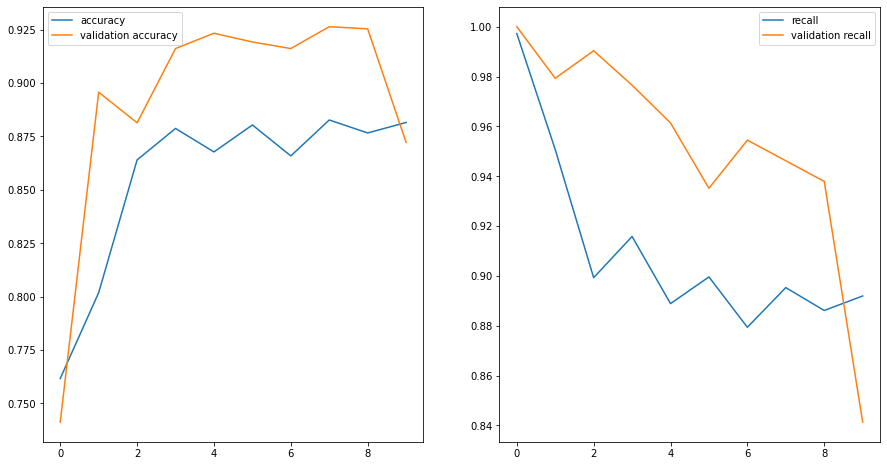

In [65]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.lineplot(complex_cnn_history3.epoch, complex_cnn_history3.history['accuracy'], ax=ax[0], label='accuracy');
sns.lineplot(complex_cnn_history3.epoch, complex_cnn_history3.history['val_accuracy'], ax=ax[0], label='validation accuracy');

sns.lineplot(complex_cnn_history3.epoch, complex_cnn_history3.history['recall_5'], ax=ax[1], label='recall');
sns.lineplot(complex_cnn_history3.epoch, complex_cnn_history3.history['val_recall_5'], ax=ax[1], label='validation recall');

In [46]:
complex_cnn_model4 = models.Sequential()
complex_cnn_model4.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.05)))
complex_cnn_model4.add(layers.MaxPooling2D((2, 2)))
complex_cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.05)))
complex_cnn_model4.add(layers.MaxPooling2D((2,2)))
complex_cnn_model4.add(layers.Flatten())
complex_cnn_model4.add(layers.Dense(16, activation='relu'))
complex_cnn_model4.add(layers.Dropout(0.3))
complex_cnn_model4.add(layers.Dense(1, activation='sigmoid'))

complex_cnn_model4.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Recall()])

complex_cnn_model4.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 39200)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                627216    
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)               

In [47]:
complex_cnn_history4 = complex_cnn_model4.fit(train_data,
                                              train_labels,
                                              batch_size=32,
                                              epochs=25,
                                              validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/25
4280/4280 [==============================] - 62s 14ms/step - loss: 0.9802 - accuracy: 0.7745 - recall_6: 0.9923 - val_loss: 0.4259 - val_accuracy: 0.8323 - val_recall_6: 0.9972
Epoch 2/25
4280/4280 [==============================] - 62s 14ms/step - loss: 0.3681 - accuracy: 0.8792 - recall_6: 0.9645 - val_loss: 0.3255 - val_accuracy: 0.8978 - val_recall_6: 0.9862
Epoch 3/25
4280/4280 [==============================] - 62s 15ms/step - loss: 0.3112 - accuracy: 0.9098 - recall_6: 0.9627 - val_loss: 0.2917 - val_accuracy: 0.9008 - val_recall_6: 0.9848
Epoch 4/25
4280/4280 [==============================] - 62s 14ms/step - loss: 0.2937 - accuracy: 0.9129 - recall_6: 0.9608 - val_loss: 0.2714 - val_accuracy: 0.9233 - val_recall_6: 0.9490
Epoch 5/25
4280/4280 [==============================] - 62s 14ms/step - loss: 0.2837 - accuracy: 0.9187 - recall_6: 0.9529 - val_loss: 0.2770 - val_accuracy: 0.8988 - val_recall_6: 0.9876
Epoch 6/25
42

In [62]:
pickle_model(complex_cnn_history4)

What would you like to name the model?CNN w Regularization and Dropout (0.3)


/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing ot

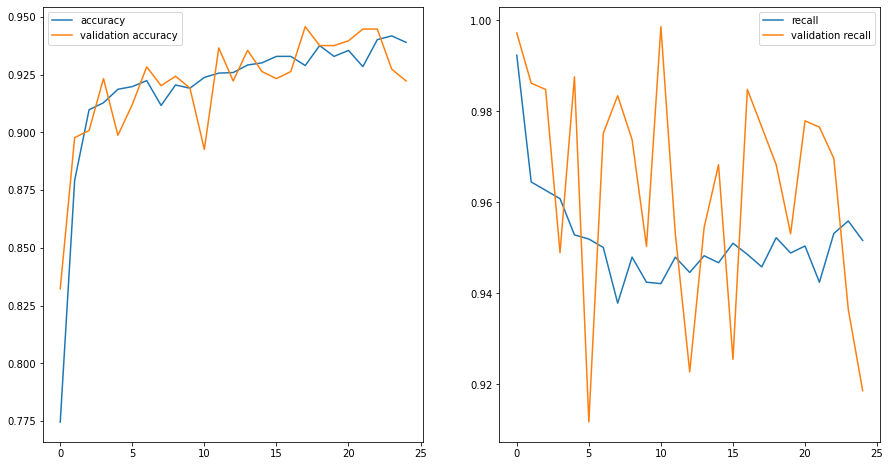

In [66]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.lineplot(complex_cnn_history4.epoch, complex_cnn_history4.history['accuracy'], ax=ax[0], label='accuracy');
sns.lineplot(complex_cnn_history4.epoch, complex_cnn_history4.history['val_accuracy'], ax=ax[0], label='validation accuracy');

sns.lineplot(complex_cnn_history4.epoch, complex_cnn_history4.history['recall_6'], ax=ax[1], label='recall');
sns.lineplot(complex_cnn_history4.epoch, complex_cnn_history4.history['val_recall_6'], ax=ax[1], label='validation recall');

In [67]:
complex_cnn_model5 = models.Sequential()
complex_cnn_model5.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model5.add(layers.MaxPooling2D((2, 2)))
complex_cnn_model5.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model5.add(layers.MaxPooling2D((2,2)))
complex_cnn_model5.add(layers.Flatten())
complex_cnn_model5.add(layers.Dense(16, activation='relu'))
complex_cnn_model5.add(layers.Dropout(0.3))
complex_cnn_model5.add(layers.Dense(1, activation='sigmoid'))

complex_cnn_model5.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Recall()])

complex_cnn_model5.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 39200)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                627216    
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)               

In [68]:
complex_cnn_history5 = complex_cnn_model5.fit(train_data,
                                              train_labels,
                                              batch_size=32,
                                              epochs=25,
                                              validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/25
4280/4280 [==============================] - 67s 16ms/step - loss: 0.7357 - accuracy: 0.7916 - recall_7: 0.9862 - val_loss: 0.4241 - val_accuracy: 0.8640 - val_recall_7: 0.9931
Epoch 2/25
4280/4280 [==============================] - 68s 16ms/step - loss: 0.3852 - accuracy: 0.8879 - recall_7: 0.9553 - val_loss: 0.3251 - val_accuracy: 0.9110 - val_recall_7: 0.9766
Epoch 3/25
4280/4280 [==============================] - 69s 16ms/step - loss: 0.3320 - accuracy: 0.9028 - recall_7: 0.9434 - val_loss: 0.2999 - val_accuracy: 0.9264 - val_recall_7: 0.9407
Epoch 4/25
4280/4280 [==============================] - 68s 16ms/step - loss: 0.3115 - accuracy: 0.9007 - recall_7: 0.9327 - val_loss: 0.2707 - val_accuracy: 0.9284 - val_recall_7: 0.9752
Epoch 5/25
4280/4280 [==============================] - 67s 16ms/step - loss: 0.3001 - accuracy: 0.9091 - recall_7: 0.9412 - val_loss: 0.3133 - val_accuracy: 0.9039 - val_recall_7: 0.9200
Epoch 6/25
42

In [69]:
pickle_model(complex_cnn_history5)

What would you like to name the model?CNN w Regularization and Dropout LR025


/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing ot

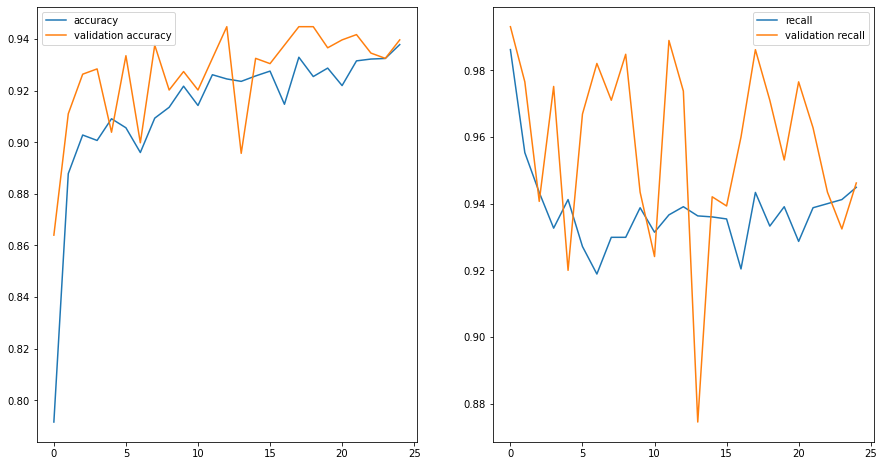

In [70]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.lineplot(complex_cnn_history5.epoch, complex_cnn_history5.history['accuracy'], ax=ax[0], label='accuracy');
sns.lineplot(complex_cnn_history5.epoch, complex_cnn_history5.history['val_accuracy'], ax=ax[0], label='validation accuracy');

sns.lineplot(complex_cnn_history5.epoch, complex_cnn_history5.history['recall_7'], ax=ax[1], label='recall');
sns.lineplot(complex_cnn_history5.epoch, complex_cnn_history5.history['val_recall_7'], ax=ax[1], label='validation recall');

In [71]:
complex_cnn_model6 = models.Sequential()
complex_cnn_model6.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model6.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model6.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model6.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model6.add(layers.Flatten())
complex_cnn_model6.add(layers.Dense(16, activation='relu'))
complex_cnn_model6.add(layers.Dropout(0.3))
complex_cnn_model6.add(layers.Dense(1, activation='sigmoid'))

complex_cnn_model6.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Recall()])

complex_cnn_model6.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 47, 47, 32)        18464     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                115216    
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)               

In [72]:
complex_cnn_history6 = complex_cnn_model6.fit(train_data,
                                              train_labels,
                                              batch_size=32,
                                              epochs=25,
                                              validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/25
4280/4280 [==============================] - 55s 13ms/step - loss: 0.6996 - accuracy: 0.8203 - recall_8: 0.9773 - val_loss: 0.3274 - val_accuracy: 0.9110 - val_recall_8: 0.9614
Epoch 2/25
4280/4280 [==============================] - 55s 13ms/step - loss: 0.3103 - accuracy: 0.8937 - recall_8: 0.9642 - val_loss: 0.2626 - val_accuracy: 0.9213 - val_recall_8: 0.9559
Epoch 3/25
4280/4280 [==============================] - 55s 13ms/step - loss: 0.2707 - accuracy: 0.9203 - recall_8: 0.9712 - val_loss: 0.2230 - val_accuracy: 0.9335 - val_recall_8: 0.9393
Epoch 4/25
4280/4280 [==============================] - 58s 14ms/step - loss: 0.2574 - accuracy: 0.9178 - recall_8: 0.9666 - val_loss: 0.3228 - val_accuracy: 0.8875 - val_recall_8: 0.9945
Epoch 5/25
4280/4280 [==============================] - 59s 14ms/step - loss: 0.2353 - accuracy: 0.9299 - recall_8: 0.9672 - val_loss: 0.2428 - val_accuracy: 0.9141 - val_recall_8: 0.9903
Epoch 6/25
42

In [74]:
pickle_model(complex_cnn_history6)


What would you like to name the model?CNN w 33 Poolings


/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing ot

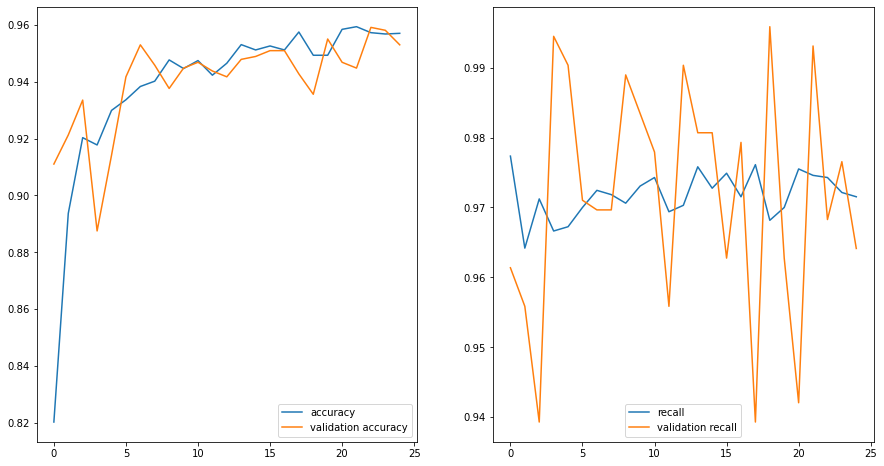

In [73]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.lineplot(complex_cnn_history6.epoch, complex_cnn_history6.history['accuracy'], ax=ax[0], label='accuracy');
sns.lineplot(complex_cnn_history6.epoch, complex_cnn_history6.history['val_accuracy'], ax=ax[0], label='validation accuracy');

sns.lineplot(complex_cnn_history6.epoch, complex_cnn_history6.history['recall_8'], ax=ax[1], label='recall');
sns.lineplot(complex_cnn_history6.epoch, complex_cnn_history6.history['val_recall_8'], ax=ax[1], label='validation recall');

In [75]:
complex_cnn_model7 = models.Sequential()
complex_cnn_model7.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model7.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model7.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model7.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model7.add(layers.Conv2D(16, (2, 2), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model7.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model7.add(layers.Flatten())
complex_cnn_model7.add(layers.Dense(16, activation='relu'))
complex_cnn_model7.add(layers.Dropout(0.3))
complex_cnn_model7.add(layers.Dense(1, activation='sigmoid'))

complex_cnn_model7.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Recall()])

complex_cnn_model7.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 47, 47, 32)        18464     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 16)        2064      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 256)              

In [76]:
complex_cnn_history7 = complex_cnn_model7.fit(train_data,
                                              train_labels,
                                              batch_size=32,
                                              epochs=25,
                                              validation_data=(val_data, val_labels))

Train on 4280 samples, validate on 978 samples
Epoch 1/25
4280/4280 [==============================] - 54s 13ms/step - loss: 1.0396 - accuracy: 0.7605 - recall_9: 0.9936 - val_loss: 0.6560 - val_accuracy: 0.7413 - val_recall_9: 1.0000
Epoch 2/25
4280/4280 [==============================] - 54s 13ms/step - loss: 0.5983 - accuracy: 0.7633 - recall_9: 1.0000 - val_loss: 0.5914 - val_accuracy: 0.7413 - val_recall_9: 1.0000
Epoch 3/25
4280/4280 [==============================] - 55s 13ms/step - loss: 0.5652 - accuracy: 0.7633 - recall_9: 1.0000 - val_loss: 0.5782 - val_accuracy: 0.7413 - val_recall_9: 1.0000
Epoch 4/25
4280/4280 [==============================] - 56s 13ms/step - loss: 0.5525 - accuracy: 0.7633 - recall_9: 1.0000 - val_loss: 0.5207 - val_accuracy: 0.7413 - val_recall_9: 1.0000
Epoch 5/25
4280/4280 [==============================] - 54s 13ms/step - loss: 0.4393 - accuracy: 0.7633 - recall_9: 1.0000 - val_loss: 0.4012 - val_accuracy: 0.7413 - val_recall_9: 1.0000
Epoch 6/25
42

/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing ot

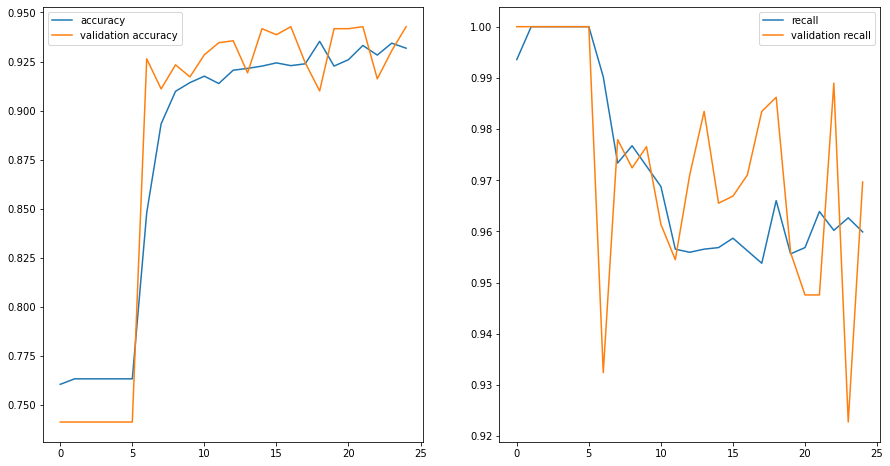

In [77]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.lineplot(complex_cnn_history7.epoch, complex_cnn_history7.history['accuracy'], ax=ax[0], label='accuracy');
sns.lineplot(complex_cnn_history7.epoch, complex_cnn_history7.history['val_accuracy'], ax=ax[0], label='validation accuracy');

sns.lineplot(complex_cnn_history7.epoch, complex_cnn_history7.history['recall_9'], ax=ax[1], label='recall');
sns.lineplot(complex_cnn_history7.epoch, complex_cnn_history7.history['val_recall_9'], ax=ax[1], label='validation recall');

In [87]:
complex_cnn_model7 = models.Sequential()
complex_cnn_model7.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model7.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model7.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model7.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model7.add(layers.Conv2D(16, (2, 2), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model7.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model7.add(layers.Flatten())
complex_cnn_model7.add(layers.Dense(16, activation='relu'))
complex_cnn_model7.add(layers.Dropout(0.3))
complex_cnn_model7.add(layers.Dense(1, activation='sigmoid'))

complex_cnn_model7.compile(optimizer="adam",
                          loss='binary_crossentropy',
                          metrics=['accuracy', metrics.Recall()])

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='max')

complex_cnn_model7.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 47, 47, 32)        18464     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 16)        2064      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 256)             

In [88]:
complex_cnn_history8 = complex_cnn_model7.fit(train_data,
                                              train_labels,
                                              batch_size=32,
                                              epochs=50,
                                              validation_data=(val_data, val_labels),
                                              callbacks=[early_stop])

Train on 4280 samples, validate on 978 samples
Epoch 1/50
4280/4280 [==============================] - 58s 14ms/step - loss: 1.0502 - accuracy: 0.7603 - recall_14: 0.9951 - val_loss: 0.6603 - val_accuracy: 0.7413 - val_recall_14: 1.0000
Epoch 2/50
4280/4280 [==============================] - 57s 13ms/step - loss: 0.6064 - accuracy: 0.7633 - recall_14: 1.0000 - val_loss: 0.5907 - val_accuracy: 0.7413 - val_recall_14: 1.0000
Epoch 3/50
4280/4280 [==============================] - 56s 13ms/step - loss: 0.5687 - accuracy: 0.7633 - recall_14: 1.0000 - val_loss: 0.5769 - val_accuracy: 0.7413 - val_recall_14: 1.0000
Epoch 4/50
4280/4280 [==============================] - 56s 13ms/step - loss: 0.5329 - accuracy: 0.7722 - recall_14: 0.9960 - val_loss: 0.4655 - val_accuracy: 0.8262 - val_recall_14: 0.9421
Epoch 5/50
4280/4280 [==============================] - 56s 13ms/step - loss: 0.4385 - accuracy: 0.8168 - recall_14: 0.9507 - val_loss: 0.3818 - val_accuracy: 0.8569 - val_recall_14: 0.9641
Epo

Epoch 44/50
4280/4280 [==============================] - 54s 13ms/step - loss: 0.2294 - accuracy: 0.9334 - recall_14: 0.9590 - val_loss: 0.1960 - val_accuracy: 0.9366 - val_recall_14: 0.9793
Epoch 45/50
4280/4280 [==============================] - 54s 13ms/step - loss: 0.2341 - accuracy: 0.9325 - recall_14: 0.9617 - val_loss: 0.1830 - val_accuracy: 0.9468 - val_recall_14: 0.9586
Epoch 46/50
4280/4280 [==============================] - 54s 13ms/step - loss: 0.2293 - accuracy: 0.9388 - recall_14: 0.9627 - val_loss: 0.1800 - val_accuracy: 0.9530 - val_recall_14: 0.9697
Epoch 47/50
4280/4280 [==============================] - 54s 13ms/step - loss: 0.2327 - accuracy: 0.9362 - recall_14: 0.9608 - val_loss: 0.1767 - val_accuracy: 0.9560 - val_recall_14: 0.9724
Epoch 48/50
4280/4280 [==============================] - 54s 13ms/step - loss: 0.2269 - accuracy: 0.9348 - recall_14: 0.9602 - val_loss: 0.1842 - val_accuracy: 0.9489 - val_recall_14: 0.9724
Epoch 49/50
4280/4280 [======================

/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing ot

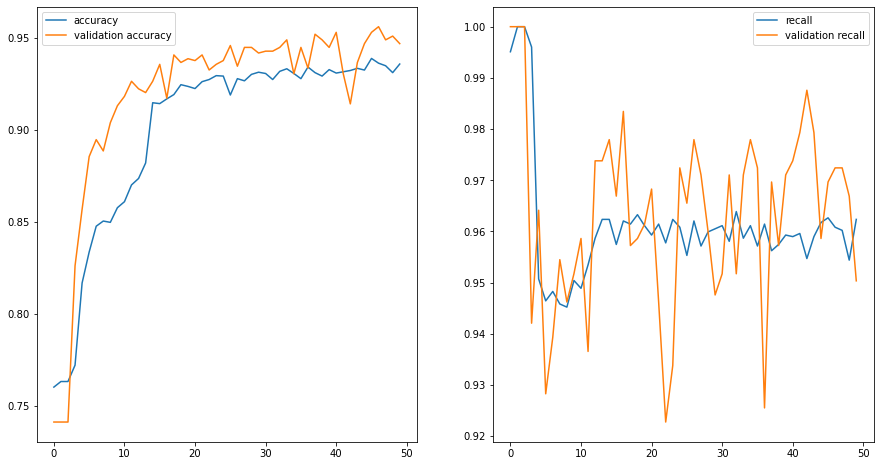

In [89]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.lineplot(complex_cnn_history8.epoch, complex_cnn_history8.history['accuracy'], ax=ax[0], label='accuracy');
sns.lineplot(complex_cnn_history8.epoch, complex_cnn_history8.history['val_accuracy'], ax=ax[0], label='validation accuracy');

sns.lineplot(complex_cnn_history8.epoch, complex_cnn_history8.history['recall_14'], ax=ax[1], label='recall');
sns.lineplot(complex_cnn_history8.epoch, complex_cnn_history8.history['val_recall_14'], ax=ax[1], label='validation recall');

In [92]:
complex_cnn_model9 = models.Sequential()
complex_cnn_model9.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model9.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model9.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model9.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model9.add(layers.Flatten())
complex_cnn_model9.add(layers.Dense(16, activation='relu'))
complex_cnn_model9.add(layers.Dropout(0.3))
complex_cnn_model9.add(layers.Dense(1, activation='sigmoid'))

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='min')

complex_cnn_model9.compile(optimizer="adam",
                           loss='binary_crossentropy',
                           metrics=['accuracy', metrics.Recall()])

complex_cnn_model9.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 47, 47, 32)        18464     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 7200)              0         
_________________________________________________________________
dense_31 (Dense)             (None, 16)                115216    
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)              

In [93]:
complex_cnn_history9 = complex_cnn_model9.fit(train_data,
                                              train_labels,
                                              batch_size=32,
                                              epochs=50,
                                              validation_data=(val_data, val_labels),
                                              callbacks=[early_stop])

Train on 4280 samples, validate on 978 samples
Epoch 1/50
4280/4280 [==============================] - 56s 13ms/step - loss: 0.7245 - accuracy: 0.8133 - recall_16: 0.9700 - val_loss: 0.5393 - val_accuracy: 0.7863 - val_recall_16: 0.7145
Epoch 2/50
4280/4280 [==============================] - 56s 13ms/step - loss: 0.3511 - accuracy: 0.8701 - recall_16: 0.9581 - val_loss: 0.2845 - val_accuracy: 0.9049 - val_recall_16: 0.9848
Epoch 3/50
4280/4280 [==============================] - 55s 13ms/step - loss: 0.2942 - accuracy: 0.8944 - recall_16: 0.9614 - val_loss: 0.3102 - val_accuracy: 0.8865 - val_recall_16: 0.9931
Epoch 4/50
4280/4280 [==============================] - 54s 13ms/step - loss: 0.2536 - accuracy: 0.9227 - recall_16: 0.9694 - val_loss: 0.1945 - val_accuracy: 0.9356 - val_recall_16: 0.9559
Epoch 5/50
4280/4280 [==============================] - 55s 13ms/step - loss: 0.2361 - accuracy: 0.9269 - recall_16: 0.9669 - val_loss: 0.1815 - val_accuracy: 0.9397 - val_recall_16: 0.9641
Epo

Epoch 44/50
4280/4280 [==============================] - 55s 13ms/step - loss: 0.1292 - accuracy: 0.9605 - recall_16: 0.9728 - val_loss: 0.1210 - val_accuracy: 0.9591 - val_recall_16: 0.9669
Epoch 45/50
4280/4280 [==============================] - 55s 13ms/step - loss: 0.1242 - accuracy: 0.9657 - recall_16: 0.9743 - val_loss: 0.1266 - val_accuracy: 0.9550 - val_recall_16: 0.9683
Epoch 46/50
4280/4280 [==============================] - 54s 13ms/step - loss: 0.1244 - accuracy: 0.9645 - recall_16: 0.9737 - val_loss: 0.1285 - val_accuracy: 0.9581 - val_recall_16: 0.9710
Epoch 47/50
4280/4280 [==============================] - 55s 13ms/step - loss: 0.1214 - accuracy: 0.9650 - recall_16: 0.9746 - val_loss: 0.1192 - val_accuracy: 0.9611 - val_recall_16: 0.9710
Epoch 48/50
4280/4280 [==============================] - 55s 13ms/step - loss: 0.1168 - accuracy: 0.9682 - recall_16: 0.9807 - val_loss: 0.1344 - val_accuracy: 0.9530 - val_recall_16: 0.9531
Epoch 49/50
4280/4280 [======================

In [94]:
pickle_model(complex_cnn_history9)

What would you like to name the model?CNN Best Recall 50 Epochs


/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing ot

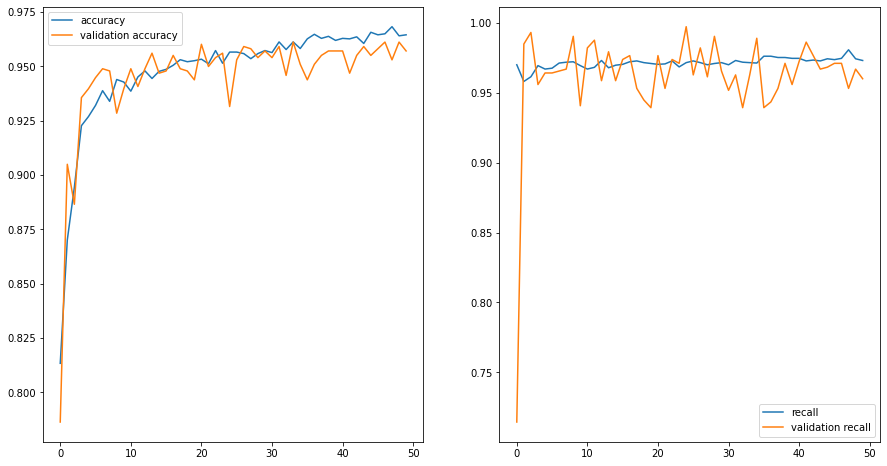

In [98]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.lineplot(complex_cnn_history9.epoch, complex_cnn_history9.history['accuracy'], ax=ax[0], label='accuracy');
sns.lineplot(complex_cnn_history9.epoch, complex_cnn_history9.history['val_accuracy'], ax=ax[0], label='validation accuracy');

sns.lineplot(complex_cnn_history9.epoch, complex_cnn_history9.history['recall_16'], ax=ax[1], label='recall');
sns.lineplot(complex_cnn_history9.epoch, complex_cnn_history9.history['val_recall_16'], ax=ax[1], label='validation recall');

In [122]:
complex_cnn_model9.save('./models/BestRecall5Threshold')

In [123]:
models.load_model('./models/BestRecall5Threshold')

AttributeError: 'str' object has no attribute 'decode'

In [95]:
def pickle_model(model):
    
    file_name = input("What would you like to name the model?")
    file_name = file_name.replace(' ', '')
    # use the built-in open() function to open a file
    output_file = open(f"./models/{file_name}.pkl", "wb") # "wb" means "write as bytes"
    # dump the variable's contents into the file
    joblib.dump(model, output_file)
    # close the file, ensuring nothing stays in the buffer
    output_file.close()

In [100]:
pickle_model(complex_cnn_model9)

What would you like to name the model?BestRecallModel


In [103]:
complex_cnn_model9.predict_classes(train_data)

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [105]:
complex_cnn_model9.evaluate(train_data, train_labels)

4280/4280 [==============================] - 11s 3ms/step


[0.08618194346673021, 0.9752336740493774, 0.9794918894767761]

In [106]:
complex_cnn_model9.evaluate(val_data, val_labels)

978/978 [==============================] - 3s 3ms/step


[0.1245029299750406, 0.9570552110671997, 0.9599999785423279]

In [107]:
complex_cnn_model7.evaluate(val_data, val_labels)

978/978 [==============================] - 3s 3ms/step


[0.17916128118589125, 0.9468302726745605, 0.9503448009490967]

In [124]:
complex_cnn_model10 = models.Sequential()
complex_cnn_model10.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model10.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model10.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model10.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model10.add(layers.Flatten())
complex_cnn_model10.add(layers.Dense(16, activation='relu'))
complex_cnn_model10.add(layers.Dropout(0.3))
complex_cnn_model10.add(layers.Dense(1, activation='sigmoid'))

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='min')

complex_cnn_model10.compile(optimizer="adam",
                           loss='binary_crossentropy',
                           metrics=['accuracy', 
                                    metrics.Recall(thresholds=0.25), 
                                    metrics.Precision(thresholds=0.25)])

complex_cnn_model10.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 47, 47, 32)        18464     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 7200)              0         
_________________________________________________________________
dense_39 (Dense)             (None, 16)                115216    
_________________________________________________________________
dropout_16 (Dropout)         (None, 16)              

In [125]:
complex_cnn_history10 = complex_cnn_model10.fit(train_data,
                                                train_labels,
                                                batch_size=32,
                                                epochs=30,
                                                validation_data=(val_data, val_labels),
                                                callbacks=[early_stop])

Train on 4280 samples, validate on 978 samples
Epoch 1/30
4280/4280 [==============================] - 59s 14ms/step - loss: 0.7316 - accuracy: 0.8042 - recall_20: 0.9988 - precision_4: 0.7795 - val_loss: 0.3330 - val_accuracy: 0.9059 - val_recall_20: 0.9986 - val_precision_4: 0.7802
Epoch 2/30
4280/4280 [==============================] - 68s 16ms/step - loss: 0.3141 - accuracy: 0.8806 - recall_20: 0.9911 - precision_4: 0.8461 - val_loss: 0.2649 - val_accuracy: 0.9151 - val_recall_20: 0.9986 - val_precision_4: 0.8162
Epoch 3/30
4280/4280 [==============================] - 60s 14ms/step - loss: 0.2702 - accuracy: 0.9154 - recall_20: 0.9911 - precision_4: 0.8571 - val_loss: 0.2298 - val_accuracy: 0.9223 - val_recall_20: 0.9986 - val_precision_4: 0.8370
Epoch 4/30
4280/4280 [==============================] - 58s 14ms/step - loss: 0.2440 - accuracy: 0.9238 - recall_20: 0.9902 - precision_4: 0.8757 - val_loss: 0.2326 - val_accuracy: 0.9172 - val_recall_20: 0.9986 - val_precision_4: 0.8380
E

/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/zacharypollatsek/opt/anaconda3/envs/tensor_lecture/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing ot

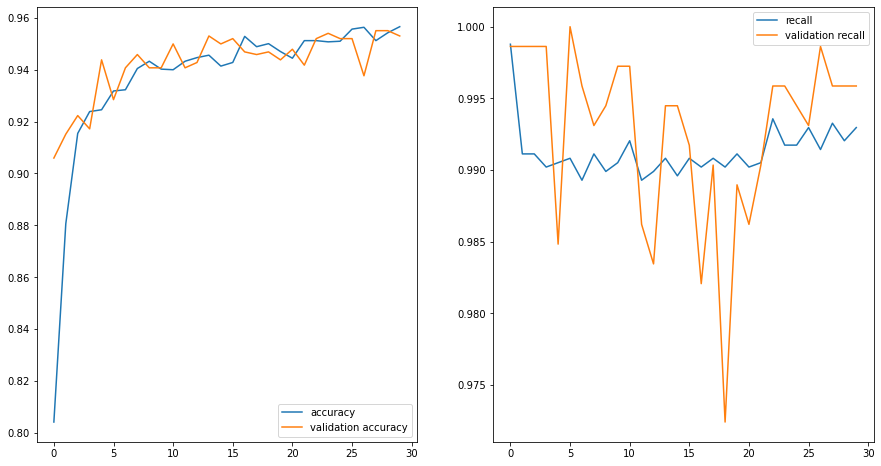

In [137]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

sns.lineplot(complex_cnn_history10.epoch, complex_cnn_history10.history['accuracy'], ax=ax[0], label='accuracy');
sns.lineplot(complex_cnn_history10.epoch, complex_cnn_history10.history['val_accuracy'], ax=ax[0], label='validation accuracy');

sns.lineplot(complex_cnn_history10.epoch, complex_cnn_history10.history['recall_20'], ax=ax[1], label='recall');
sns.lineplot(complex_cnn_history10.epoch, complex_cnn_history10.history['val_recall_20'], ax=ax[1], label='validation recall');

In [127]:
complex_cnn_model10.save('./models/UpdatedThreshold25')

In [10]:
complex_cnn_model13 = models.Sequential()
complex_cnn_model13.add(layers.Conv2D(64, (4, 4), activation='relu',
                       input_shape=(150, 150, 1), kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model13.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model13.add(layers.Conv2D(32, (3, 3), activation='relu', 
                                     kernel_regularizer=regularizers.l2(l=0.025)))
complex_cnn_model13.add(layers.MaxPooling2D((3, 3)))
complex_cnn_model13.add(layers.Flatten())
complex_cnn_model13.add(layers.Dense(16, activation='relu'))
complex_cnn_model13.add(layers.Dropout(0.3))
complex_cnn_model13.add(layers.Dense(1, activation='sigmoid'))

# Define the EarlyStopping object
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-8,
                           patience=10,
                           verbose=1,
                           mode='min')

complex_cnn_model13.compile(optimizer="adam",
                           loss='binary_crossentropy',
                           metrics=['accuracy', 
                                    metrics.Recall(thresholds=0.3), 
                                    metrics.Precision(thresholds=0.3)])

complex_cnn_model13.summary()

2022-08-03 14:55:30.678868: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-03 14:55:30.681006: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 147, 147, 64)      1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                115216    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0

In [12]:
complex_cnn_history13 = complex_cnn_model13.fit(train_data,
                                                train_labels,
                                                batch_size=32,
                                                epochs=50,
                                                validation_data=(val_data, val_labels),
                                                callbacks=[early_stop])

Train on 3749 samples, validate on 936 samples
Epoch 1/50
3749/3749 [==============================] - 47s 12ms/sample - loss: 0.6854 - accuracy: 0.7567 - recall: 1.0000 - precision: 0.7298 - val_loss: 0.3950 - val_accuracy: 0.8782 - val_recall: 1.0000 - val_precision: 0.7297
Epoch 2/50
3749/3749 [==============================] - 46s 12ms/sample - loss: 0.3973 - accuracy: 0.8757 - recall: 1.0000 - precision: 0.7298 - val_loss: 0.3452 - val_accuracy: 0.8910 - val_recall: 1.0000 - val_precision: 0.7297
Epoch 3/50
3749/3749 [==============================] - 47s 13ms/sample - loss: 0.3578 - accuracy: 0.9029 - recall: 1.0000 - precision: 0.7298 - val_loss: 0.3091 - val_accuracy: 0.9220 - val_recall: 1.0000 - val_precision: 0.7297
Epoch 4/50
3749/3749 [==============================] - 47s 13ms/sample - loss: 0.3410 - accuracy: 0.9074 - recall: 1.0000 - precision: 0.7298 - val_loss: 0.3210 - val_accuracy: 0.8889 - val_recall: 1.0000 - val_precision: 0.7297
Epoch 5/50
3749/3749 [===========

3749/3749 [==============================] - 43s 11ms/sample - loss: 0.1713 - accuracy: 0.9539 - recall: 0.9821 - precision: 0.9566 - val_loss: 0.1608 - val_accuracy: 0.9509 - val_recall: 0.9956 - val_precision: 0.9264
Epoch 37/50
3749/3749 [==============================] - 43s 11ms/sample - loss: 0.1754 - accuracy: 0.9515 - recall: 0.9821 - precision: 0.9528 - val_loss: 0.1730 - val_accuracy: 0.9476 - val_recall: 0.9956 - val_precision: 0.9214
Epoch 38/50
3749/3749 [==============================] - 43s 12ms/sample - loss: 0.1753 - accuracy: 0.9509 - recall: 0.9781 - precision: 0.9550 - val_loss: 0.1555 - val_accuracy: 0.9541 - val_recall: 0.9868 - val_precision: 0.9480
Epoch 39/50
3749/3749 [==============================] - 43s 11ms/sample - loss: 0.1717 - accuracy: 0.9544 - recall: 0.9814 - precision: 0.9535 - val_loss: 0.1464 - val_accuracy: 0.9637 - val_recall: 0.9883 - val_precision: 0.9467
Epoch 40/50
3749/3749 [==============================] - 43s 11ms/sample - loss: 0.1698 

In [13]:
complex_cnn_model13.evaluate(val_data, val_labels)

936/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.1500746447306413, 0.9561966, 0.98682284, 0.95602834]

In [14]:
complex_cnn_model13.evaluate(train_data, train_labels)

3749/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.12800534018264448, 0.96879166, 0.9868421, 0.9635974]

In [15]:
probs = complex_cnn_model13.predict(val_data)

In [17]:
import numpy as np

In [105]:
prob_class = np.where(probs > 0.25, 1, 0)

In [106]:
from sklearn.metrics import confusion_matrix

In [107]:
conf = confusion_matrix(val_labels, prob_class)

<AxesSubplot:>

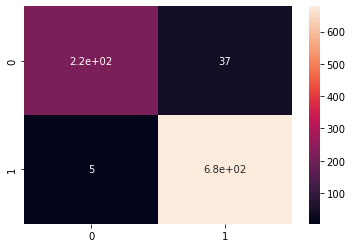

In [108]:
sns.heatmap(conf, annot=True)